In [29]:
import os
import sys
# module_path = os.path.abspath(os.path.join('.'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
def ipy_path_append(root=None):
    r = root if root is not None else os.getcwd()
    for path in os.listdir(r):
        if os.path.isdir(path):
            ipy_path_append(path)
            if path not in sys.path:
                sys.path.append(path)
ipy_path_append()
# for p in face_lib_path:
#     if p not in sys.path:
#         sys.path.append(module_path)

import torch
import numpy as np
from tqdm import tqdm

from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Dataset
from PIL import Image
from matplotlib import pyplot as plt
import itertools
from torchvision.models import vgg16,VGG16_Weights, resnet101,ResNet101_Weights
import torch.nn as nn

from lib import mtcnn
from lib.mobilefacenet import MobileFaceNet,Arcface


In [120]:
#### Config Values ###

IMG_SHAPE = (112,112,3)
BATCH_SIZE = 128
EPOCHS = 40
SHUFFLE = True
SEED = 42

CLASSES_T =['unknown','1','2'] 
CLASSES_B =['0','1','2'] 
TRAIN_PATH = r"C:\Users\asiclab06\Datasets\faces_vgg_112x112\imgs" #r"C:\Users\asiclab06\Datasets\afhq\train"
TEST_PATH =  r"C:\Users\asiclab06\Datasets\faces_vgg_112x112\imgs" #r"C:\Users\asiclab06\Datasets\afhq\val"

PRE_MODEL_PATH = r"lib\pre_trained\mfn_2023-02-02_acc0.9290.pth"

In [56]:
## Define Dataset

class ImageDataset(Dataset):
    def __init__(self,root,classes,target_size:tuple,shuffle=False,**kwargs):
        super().__init__()
        self.root=  root
        self.classes = [str(c) for c in classes]
        self.target_size = target_size if not type(classes) is int else (target_size,target_size)
        self.shuffle = shuffle        

        self._load_data()
        self._set_index_array()     
        self._set_shuffle()
    
        # kwargs
        self.samples = kwargs.pop('samples',None)
        if self.samples is not None:
            self._sampling_data()

    def _sampling_data(self):
        s = np.random.choice(self.__len__()-self.samples,1).item() if self.shuffle else 0
        e = self.samples
        self.data = self.data[s:e+s]
        self.label = self.label[s:e+s]

    def _load_data(self):
        self.data = []
        self.label = []

        for i,cla in enumerate(self.classes):
            sub_dir = os.path.join(self.root,cla)
            if not os.path.exists(sub_dir):
                print(f'Not found images in "{cla}" directory.')
                continue
            sub_files = os.listdir(sub_dir)
            self.data.extend([os.path.join(sub_dir,sub_file) for sub_file in sub_files])
            l=len(sub_files)
            self.label.extend([i for _ in range(l)])
            print(f'Found {l} images in "{cla}" directory.')

        self.data = np.array(self.data) 
        self.label = np.array(self.label)
        
    def _set_index_array(self):
        self.index_array = np.arange(self.__len__())
        if self.shuffle:
            self.index_array = np.random.permutation(self.__len__())

    def _set_shuffle(self):
        self.data = self.data[self.index_array]
        self.label = self.label[self.index_array]

    def __getitem__(self, index):
        """
            Return : PIL image, sparse label
        """
        x = Image.open(self.data[index]).convert('RGB')
        x = x.resize(self.target_size[:2],Image.Resampling.BILINEAR)
        

        return x, self.label[index]

    def __len__(self):
        return len(self.data)

class FaceClfDataset(ImageDataset):
    def __init__(self, root, classes, target_size: tuple, shuffle=False, transform=None, class_mode=None, **kwargs):
        super().__init__(root, classes, target_size, shuffle, **kwargs)
        # transform
        if transform is not None:
            self.transform = transform
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
            ])

        self.allow_class_modes =  ["categorical","sparse",None]

        if class_mode is not None:
            self.class_mode = class_mode
        else:
            self.class_mode = self.allow_class_modes[0]

    def _class_mode(self,y):
        if self.class_mode == self.allow_class_modes[0]:
            return self._to_categorical_class(y)
        elif self.class_mode == self.allow_class_modes[1]:
            return torch.tensor(y,dtype=torch.long)

    def _to_categorical_class(self,y):
        temp = torch.zeros((len(self.classes),),dtype=torch.long)
        temp[y] = 1
        return temp 

    def categorical2sparse(y:torch.Tensor):
        return torch.argmax(y,1)

    def __getitem__(self, index):
        x,y = super().__getitem__(index)
        return self.transform(x),self._class_mode(y)

    def get_sample(self, index):
        return super().__getitem__(index)

    def __len__(self):
        return super().__len__()    

def get_train_dataset(imgs_folder):
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    ds = ImageFolder(imgs_folder, train_transform)
    class_num = ds[-1][1] + 1 # tuple[tensor, label] label + 1
    return ds, class_num

train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

In [67]:
## train, val set
train_dataset = FaceClfDataset(TRAIN_PATH,CLASSES_T,(IMG_SHAPE),SHUFFLE,transform=train_transform,class_mode='categorical')
train_loader = DataLoader(train_dataset,BATCH_SIZE,SHUFFLE)

test_dataset = FaceClfDataset(TEST_PATH,CLASSES_B,(IMG_SHAPE),False,transform=train_transform,class_mode='sparse')
test_loader = DataLoader(test_dataset,BATCH_SIZE,False)


Not found images in "unknown" directory.
Found 205 images in "1" directory.
Found 385 images in "2" directory.
Found 229 images in "3" directory.
Found 205 images in "1" directory.
Found 385 images in "2" directory.


In [112]:
## utills 

def wrap_generator(generator):
    while True:
        x,y = next(iter(generator))
        zeros = torch.zeros_like(y) + torch.Tensor([1.,0.,0.]) # add fake label
        y = torch.concat([y,zeros], axis=0)
        yield x,y

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues,cm_proba=True):
    if cm_proba:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

def plot_confusion_matrix_detail(cm,classes):
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plot_confusion_matrix(cm,classes)
    plt.subplot(122)
    plot_confusion_matrix(cm,classes,cm_proba=False)
    
def sample_from_derectory(base_path=TEST_PATH,labels=CLASSES_T): # func only this file
    f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (16,7))
    samples = []
    for ax in axes.ravel():
        label = np.random.choice(labels)#np.random.choice(os.listdir(base_path))
        i = np.where(np.array(labels)==label)[0]
        img = np.random.choice(os.listdir(os.path.join(base_path, label)))
        img = Image.open(os.path.join(base_path, label) + "/" + img) # os.path.join
        img = img.resize(IMG_SHAPE[:2],resample=Image.Resampling.NEAREST)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label+" "+str(i))  
        samples.append(np.array(img))
    
    return np.array(samples)

def plot_result(samples,preds,true_label=None,labels=CLASSES_B):
    f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (16,7))
    
    for i,ax in enumerate(axes.ravel()):
        label = labels[preds[i]]
        l = preds[i]
        img = Image.fromarray(samples[i])
        ax.imshow(img)
        ax.axis('off')
        ax.set_title("P : "+label+" "+str(l))  

class VerboseExecution(nn.Module):
    def __init__(self, model: nn.Module,permute = True):
        super().__init__()
        self.model = model
        self.layer_output = []

        def trans(tensor:torch.Tensor):
            try:
                return tensor.permute(0,2,3,1).data.numpy()
            except:
                return tensor.data.numpy()
        # Register a hook for each layer
        for name, layer in self.model.named_children():
            layer.__name__ = name
            layer.register_forward_hook(
                lambda layer, _, output: print(f"{layer.__name__}: {output.shape}")
            )
            layer.register_forward_hook(
                lambda layer, input, output: self.layer_output.append([layer.__name__,(trans(output) if permute else output)])
            )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            self.model(x)
        return x

class ConfusionMatrix:
    def __init__(self,classes = None):
        self.cm = None

        if classes is not None:
            self.classes = classes
            self.n_classes = len(classes)

    def get_conf_matrix(self,actual,pred):
        if self.classes is None:
            self.classes = torch.unique(actual)
            self.n_classes = len(self.classes)
        conf_matrix = torch.zeros((self.n_classes, self.n_classes), dtype=torch.int32)
        for i in range(self.n_classes):
            for j in range(self.n_classes):
                conf_matrix[i, j] = torch.sum((actual == self.classes[i]) & (pred == self.classes[j]))

        return conf_matrix

    def update(self,actual,pred):

        curr_cm = self.get_conf_matrix(actual,pred)
        if self.cm is not None:
            self.cm += curr_cm
        else:
            self.cm = curr_cm

    def get_acc(self):
        _sum = 0
        tp = 0
        for i in range(self.n_classes):
            for j in range(self.n_classes):
                _sum += self.cm[i,j]
                if i == j:
                    tp += self.cm[i,j]
        return tp / _sum
        
    def get_result(self):
        return self.cm

class History:
    def __init__(self):
        self.train_loss = []
        self.valid_loss = []
        self.train_acc = []
        self.valid_acc = []

    def append(self, train_loss, valid_loss, train_acc, valid_acc):
        self.train_loss.append(train_loss)
        self.valid_loss.append(valid_loss)
        self.train_acc.append(train_acc)
        self.valid_acc.append(valid_acc)

    def calculate_loss(self, actual, pred):
        criterion = torch.nn.MSELoss()
        loss = criterion(actual, pred)
        return loss.item()

    def calculate_accuracy(self, actual, pred):
        pred = torch.round(pred)
        correct = (pred == actual).sum().item()
        accuracy = correct / len(actual)
        return accuracy
    


In [59]:
## models 

def get_vgg16(n_classes,device = torch.device('cuda:0')):
    vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    for param in vgg.parameters():
        param.requires_grad = False

    # clf.add_module(str(clf.__len__()),
    #     nn.Linear(in_features=4096, out_features=n_classes, bias=True))
    clf = nn.Sequential(
        nn.Linear(in_features=4096, out_features=512, bias=False),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=128, bias=False),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=n_classes+1, bias=False),
    )
    return nn.Sequential(vgg.features,nn.Flatten(),vgg.classifier[:1]).to(device),clf.to(device)

def get_resnet101(n_classes,device = torch.device('cuda:0')):
    resnet = resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)
    for param in resnet.parameters():
        param.requires_grad = False

    clf = nn.Sequential(
        nn.Linear(in_features=2048, out_features=512, bias=False),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=128, bias=False),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=n_classes+1, bias=False),
    )
    return nn.Sequential(*[_ for _ in resnet.children()][:-1],nn.Flatten()).to(device),clf.to(device)

def get_mobilefacenet(n_classes,device = torch.device('cuda:0')):
    mfn = MobileFaceNet(512)
    mfn.load_state_dict(torch.load(PRE_MODEL_PATH,map_location='cpu'))

    for param in mfn.parameters():
        param.requires_grad = False

    clf = nn.Sequential(
        nn.Linear(in_features=512, out_features=512, bias=False),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=128, bias=False),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=n_classes+1, bias=False),
    )
    return mfn.to(device), clf.to(device)


class BoNet(nn.Module):
    def __init__(self,n_classes,backbone,b_out_v:str,device):
        """
        Args: 
            n_classes : trainning classes number. ex. ['cat','dog'] => n_classes = 2
            backbone : current allow model [vgg16, resnet101,mobilefacenet] 
        """
        super().__init__()

        # config values        
        self.device = device
        self.n_classes = n_classes
        self.backbone, self.clf = self._get_backbone(backbone)
        self.b_name = backbone
        self.b_v_n = b_out_v 

        # network
        self.inm = nn.InstanceNorm1d(1,affine=False)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(self.b_v_n) # if self.b_name == 'vgg16' else nn.BatchNorm1d(2048)
        # self.head = Arcface(embedding_size=512,classnum= self.n_classes).to(self.device)

        # history
        self.history = History()

        # device
        if self.device == torch.device('cuda:0'):
            self.cuda()
        else:
            self.cpu()
        a = next(self.backbone.parameters()).device
        print(f"Model : {backbone} device: {a}")
    
    def _get_backbone(self,b):
        if b not in ['vgg16','resnet101','mobilefacenet']:
            raise Exception('not support model.')

        return eval(f'get_{b}(self.n_classes,"{self.device}")')

    def forward(self,x):
        x = self.backbone(x)
        x = self.relu(self.bn(x))
        
        if self.training:
            unk_vector = torch.normal(0.,0.01,x.shape,device=self.device)
            x = x.view(-1,1,self.b_v_n) # 4096, 2048
            x = self.inm(x)
            x = x.view(-1,self.b_v_n) # 4096, 2048
            x = torch.vstack([x,unk_vector])
            x = self.relu(x)
        else :
            x = x

        x = self.clf(x)

        return x

    def fit(self,
        train_generator,
        epochs,
        lr,
        device,
        val_generator=None
        ):
        criterion = nn.CrossEntropyLoss()
        optim = torch.optim.Adam(self.clf.parameters(),lr=lr)
        
        for ep in range(epochs):
            train_loss = 0.
            self.train()
            i=0
            cm = ConfusionMatrix(range(self.n_classes+1))
            for x,y in tqdm(train_generator):
                # if onehot y
                z = torch.zeros((self.n_classes+1,)) # add fake label
                z[0] = 1
                # if sparse
                # z = torch.zeros((BATCH_SIZE))
                
                # print(z.shape, y)#torch.zeros_like(y).shape )
                zeros = torch.zeros_like(y) + z
                y = torch.concat([y,zeros], axis=0)
                x = x.to(device)
                y = y.to(device)

                pred = self.forward(x)
                loss = criterion(pred,y)
                optim.zero_grad()
                loss.backward()
                optim.step()
                
                cm.update(torch.argmax(y,1),torch.argmax(pred,1))
                train_loss += loss.item()
                i += 1

            print(f"train loss : {train_loss/i} train acc : {cm.get_acc()}")


    def predict(self,test_generator):
        cm = ConfusionMatrix(range(self.n_classes+1))
        self.eval()
        for x,y in tqdm(test_generator):
            x = x.to(self.device)
            y = y.to(self.device)

            pred = torch.argmax(torch.softmax(self.forward(x),1),1)
            cm.update(y,pred)
            
        return cm.get_result()
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
c = BoNet(2,'mobilefacenet',512,device)



Model : mobilefacenet device: cuda:0


In [60]:
## BoN train

# train_dataset = FaceClfDataset(r"data\train",['unkown','cats','dogs'],(IMG_SHAPE),SHUFFLE,class_mode='categorical')
# train_loader = DataLoader(train_dataset,BATCH_SIZE,SHUFFLE)

# test_dataset = FaceClfDataset(r'data\test',['wild','cats','dogs'],(IMG_SHAPE),False,class_mode='sparse')
# test_loader = DataLoader(test_dataset,BATCH_SIZE,False)

c.fit(train_loader,40,1e-3,device)


100%|██████████| 5/5 [00:00<00:00,  7.36it/s]


train loss : 0.8835749745368957 train acc : 0.4559321999549866


100%|██████████| 5/5 [00:00<00:00,  9.32it/s]


train loss : 0.596409547328949 train acc : 0.498305082321167


100%|██████████| 5/5 [00:00<00:00,  8.74it/s]


train loss : 0.5762947797775269 train acc : 0.4991525411605835


100%|██████████| 5/5 [00:00<00:00,  9.08it/s]


train loss : 0.5701915144920349 train acc : 0.5


100%|██████████| 5/5 [00:00<00:00,  9.33it/s]


train loss : 0.5611183404922485 train acc : 0.5


100%|██████████| 5/5 [00:00<00:00,  9.50it/s]


train loss : 0.5504059553146362 train acc : 0.5


100%|██████████| 5/5 [00:00<00:00,  8.74it/s]


train loss : 0.5452044844627381 train acc : 0.5245762467384338


100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


train loss : 0.544477915763855 train acc : 0.5389830470085144


100%|██████████| 5/5 [00:00<00:00,  8.07it/s]


train loss : 0.5372262835502625 train acc : 0.503389835357666


100%|██████████| 5/5 [00:00<00:00,  8.11it/s]


train loss : 0.5337283134460449 train acc : 0.5


100%|██████████| 5/5 [00:00<00:00,  7.61it/s]


train loss : 0.5317985892295838 train acc : 0.5296609997749329


100%|██████████| 5/5 [00:00<00:00,  8.26it/s]


train loss : 0.5211612105369567 train acc : 0.5822033882141113


100%|██████████| 5/5 [00:00<00:00,  8.17it/s]


train loss : 0.5110886812210083 train acc : 0.5177966356277466


100%|██████████| 5/5 [00:00<00:00,  8.27it/s]


train loss : 0.5009910702705384 train acc : 0.6135593056678772


100%|██████████| 5/5 [00:00<00:00,  8.11it/s]


train loss : 0.5015744507312775 train acc : 0.7059321999549866


100%|██████████| 5/5 [00:00<00:00,  8.17it/s]


train loss : 0.49163957834243777 train acc : 0.5042372941970825


100%|██████████| 5/5 [00:00<00:00,  7.97it/s]


train loss : 0.47582449913024905 train acc : 0.7118644118309021


100%|██████████| 5/5 [00:00<00:00,  7.70it/s]


train loss : 0.4552671790122986 train acc : 0.8110169768333435


100%|██████████| 5/5 [00:00<00:00,  8.11it/s]


train loss : 0.45927579402923585 train acc : 0.7559322118759155


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


train loss : 0.4465393006801605 train acc : 0.9237288236618042


100%|██████████| 5/5 [00:00<00:00,  8.14it/s]


train loss : 0.4517204463481903 train acc : 0.5


100%|██████████| 5/5 [00:00<00:00,  8.14it/s]


train loss : 0.4335127234458923 train acc : 0.5008474588394165


100%|██████████| 5/5 [00:00<00:00,  8.18it/s]


train loss : 0.4141382873058319 train acc : 0.8415254354476929


100%|██████████| 5/5 [00:00<00:00,  8.25it/s]


train loss : 0.40890958309173586 train acc : 0.9533898234367371


100%|██████████| 5/5 [00:00<00:00,  7.77it/s]


train loss : 0.41053285002708434 train acc : 0.6127118468284607


100%|██████████| 5/5 [00:00<00:00,  8.07it/s]


train loss : 0.3976911723613739 train acc : 0.8203389644622803


100%|██████████| 5/5 [00:00<00:00,  8.08it/s]


train loss : 0.3947617709636688 train acc : 0.8762711882591248


100%|██████████| 5/5 [00:00<00:00,  8.29it/s]


train loss : 0.41047185063362124 train acc : 0.5008474588394165


100%|██████████| 5/5 [00:00<00:00,  8.18it/s]


train loss : 0.40935168862342836 train acc : 0.5


100%|██████████| 5/5 [00:00<00:00,  8.18it/s]


train loss : 0.3842644453048706 train acc : 0.6101694703102112


100%|██████████| 5/5 [00:00<00:00,  8.16it/s]


train loss : 0.3666286885738373 train acc : 0.9694915413856506


100%|██████████| 5/5 [00:00<00:00,  7.76it/s]


train loss : 0.36957908272743223 train acc : 0.7330508232116699


100%|██████████| 5/5 [00:00<00:00,  8.14it/s]


train loss : 0.3654974937438965 train acc : 0.7161017060279846


100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


train loss : 0.3609201431274414 train acc : 0.9644067883491516


100%|██████████| 5/5 [00:00<00:00,  8.10it/s]


train loss : 0.4131279170513153 train acc : 0.7610169649124146


100%|██████████| 5/5 [00:00<00:00,  8.14it/s]


train loss : 0.3983621299266815 train acc : 0.5008474588394165


100%|██████████| 5/5 [00:00<00:00,  8.15it/s]


train loss : 0.3919462561607361 train acc : 0.5720338821411133


100%|██████████| 5/5 [00:00<00:00,  8.10it/s]


train loss : 0.36973785758018496 train acc : 0.8762711882591248


100%|██████████| 5/5 [00:00<00:00,  7.67it/s]


train loss : 0.34829590916633607 train acc : 0.9847457408905029


100%|██████████| 5/5 [00:00<00:00,  7.76it/s]

train loss : 0.3351286470890045 train acc : 0.993220329284668


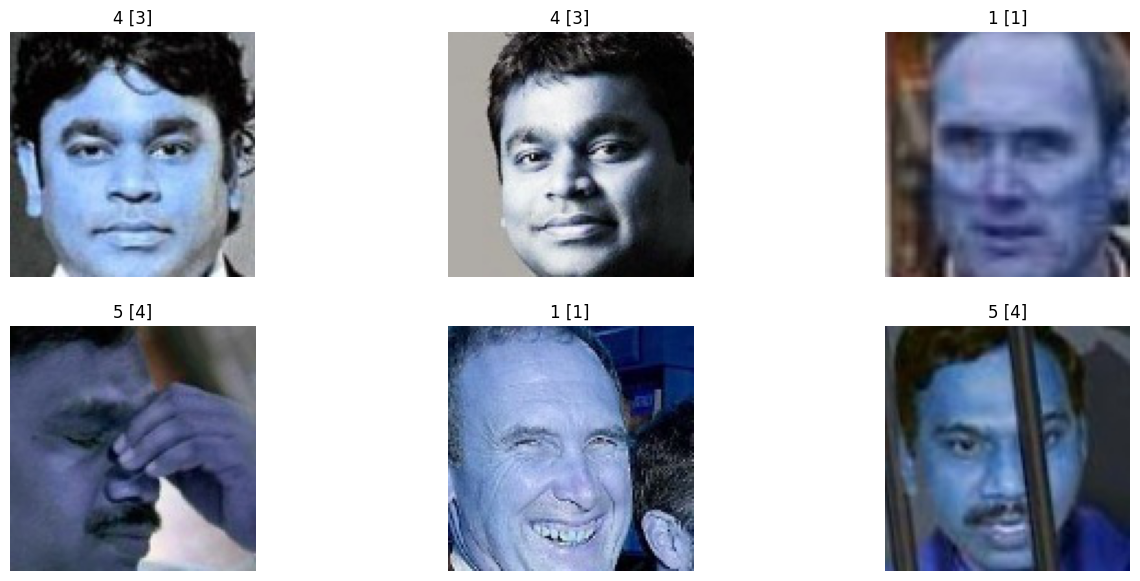

In [128]:
samples = sample_from_derectory(labels=['3','1','2','4','5'])

In [129]:
import time
t = time.time()
c.eval()
inp = torch.from_numpy(samples/255)
inp = inp.permute(0,3,1,2).float().to('cuda:0')
inp = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(inp)
preds = torch.softmax(c(inp),1)
preds = torch.argmax(preds,1)
t2 = time.time()

preds,t2-t

(tensor([0, 0, 0, 0, 1, 0], device='cuda:0'), 0.008217573165893555)

In [123]:
re = c.predict(test_loader)

100%|██████████| 8/8 [00:01<00:00,  6.47it/s]


In [124]:
re

tensor([[306,   3,   6],
        [ 25, 180,   0],
        [ 13,   0, 372]], dtype=torch.int32)

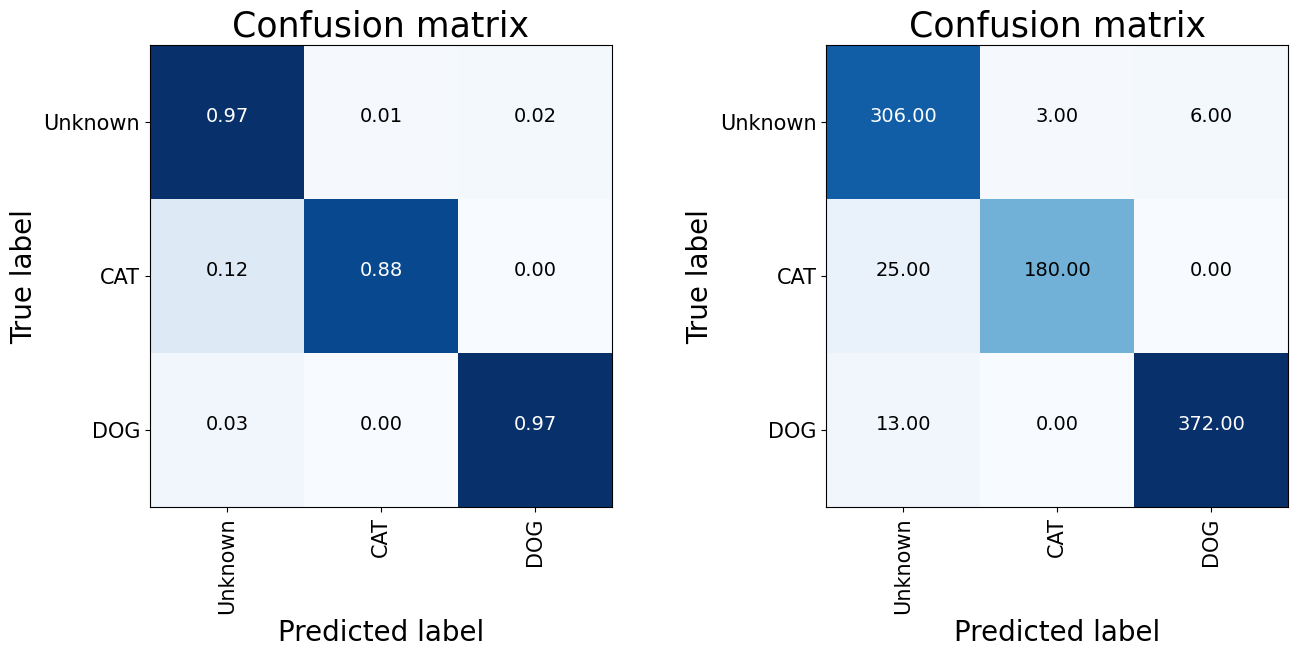

In [125]:
plot_confusion_matrix_detail(re.numpy(), classes=['Unknown','CAT','DOG'])
plt.show()

In [126]:
def classfication_report(cm,keys = CLASSES_T):
    assert not type(cm) is list , Exception('keys type error, not support list type')

    print(np.sum(np.sum(cm)))
    targets = len(keys)
    margin = 3
    first_width = max(9,*[len(k) for k in keys])
    
    # todo: no yame
    margins = [first_width+margin+len('precision'),len('recall')+margin,len('f1-score')+margin]
    print(f"{'precision':>{margins[0]+1}} {'recall':>{margins[1]+3}} {'f1-score':>{margins[2]+3}}")
    margins = [m - first_width for m in margins]
    
    # macro
    macro_pre = 0.
    macro_re = 0.
    macro_f1 = 0.
    for target in range(targets):
        precision = cm[target,target] / sum(cm[:,target])
        recall = cm[target,target] / sum(cm[target,:])
        f1 = 2*(1/(1/recall + 1/precision))
        print(f"{keys[target]:>{first_width}s} {precision:>{margins[0]}.4f} {recall:>{sum(margins[:2])}.4f} {f1:>{sum(margins[:])}.4f}")
        macro_pre+=precision
        macro_re+=recall
        macro_f1+=f1
    print()
    print(f"{'macro avg':>{first_width+margins[1]}s} {macro_pre/targets:>{margins[0]}.4f} {macro_re/targets:>{sum(margins[:2])}.4f} {macro_f1/targets:>{sum(margins[:])}.4f}")
    
    # micro
    TP = sum(np.diag(cm))
    FP = np.sum(cm, axis=0) - np.diag(cm)
    FN = np.sum(cm, axis=1) - np.diag(cm)
    acc = TP/sum(sum(cm))
    micro_pre = np.sum(TP) / (np.sum(TP) + np.sum(FP))
    micro_re = np.sum(TP) / (np.sum(TP) + np.sum(FN))
    micro_f1 = 2 * micro_pre * micro_re / (micro_pre + micro_re)
    
    print(f"{'micro avg':>{first_width+margins[1]}s} {micro_pre:>{margins[0]}.4f} {micro_re:>{sum(margins[:2])}.4f} {micro_f1:>{sum(margins[:])}.4f}")
    print(f"{'accuarcy':>{first_width+margins[1]}s} {'':>{margins[0]}s} {'':>{sum(margins[:2])}s} {acc:>{sum(margins[:])}.4f}")
        # todo : support pass
classfication_report(re.numpy())

905
             precision       recall       f1-score
  unknown       0.8895       0.9714         0.9287
        1       0.9836       0.8780         0.9278
        2       0.9841       0.9662         0.9751

macro avg       0.9524       0.9386         0.9439
micro avg       0.9481       0.9481         0.9481
 accuarcy                                   0.9481


In [77]:
# face job
from torch.utils.data import random_split

train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

ids = range(8632) # vgg
test_uk = ids[:3]
train_ids = ids[3:]

class_train = ['unknown','1','2']
class_test = ['0','1','2']

train_dataset = FaceClfDataset(r"C:\Users\asiclab06\Datasets\faces_vgg_112x112\imgs",class_train,
               IMG_SHAPE,False,train_transform,class_mode='categorical')

test_dataset = FaceClfDataset(r"C:\Users\asiclab06\Datasets\faces_vgg_112x112\imgs",class_test,
               IMG_SHAPE,False,train_transform,class_mode='sparse')

train_size = int(0.8 * train_dataset.__len__())
test_size = train_dataset.__len__()- train_size
train_dataset, val_dataset = random_split(train_dataset,[train_size,test_size])


Not found images in "unknown" directory.
Found 205 images in "1" directory.
Found 385 images in "2" directory.
Found 315 images in "0" directory.
Found 205 images in "1" directory.
Found 385 images in "2" directory.


In [80]:
train_loader = DataLoader(train_dataset,BATCH_SIZE,SHUFFLE)
test_loader = DataLoader(test_dataset,BATCH_SIZE,SHUFFLE)
val_loader = DataLoader(val_dataset,BATCH_SIZE,SHUFFLE)
c = BoNet(len(class_train)-1,'mobilefacenet',512,device)
c.fit(train_loader,80,3e-4,device)

Model : mobilefacenet device: cuda:0


100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


train loss : 1.029115542769432 train acc : 0.3930084705352783


100%|██████████| 4/4 [00:00<00:00,  9.15it/s]


train loss : 0.8585252463817596 train acc : 0.41101694107055664


100%|██████████| 4/4 [00:00<00:00,  9.33it/s]


train loss : 0.7322590947151184 train acc : 0.46398305892944336


100%|██████████| 4/4 [00:00<00:00,  9.30it/s]


train loss : 0.6436886638402939 train acc : 0.4925847351551056


100%|██████████| 4/4 [00:00<00:00,  8.34it/s]


train loss : 0.6001025140285492 train acc : 0.49788135290145874


100%|██████████| 4/4 [00:00<00:00,  8.00it/s]


train loss : 0.5795630365610123 train acc : 0.49894067645072937


100%|██████████| 4/4 [00:00<00:00,  7.41it/s]


train loss : 0.5718639940023422 train acc : 0.49894067645072937


100%|██████████| 4/4 [00:00<00:00,  8.11it/s]


train loss : 0.568500354886055 train acc : 0.5


100%|██████████| 4/4 [00:00<00:00,  8.13it/s]


train loss : 0.5664681792259216 train acc : 0.5


100%|██████████| 4/4 [00:00<00:00,  8.12it/s]


train loss : 0.5661395788192749 train acc : 0.49894067645072937


100%|██████████| 4/4 [00:00<00:00,  8.12it/s]


train loss : 0.5632523596286774 train acc : 0.5


100%|██████████| 4/4 [00:00<00:00,  7.98it/s]


train loss : 0.5616132169961929 train acc : 0.5


100%|██████████| 4/4 [00:00<00:00,  8.18it/s]


train loss : 0.5609128177165985 train acc : 0.5


100%|██████████| 4/4 [00:00<00:00,  8.21it/s]


train loss : 0.5589028596878052 train acc : 0.5


100%|██████████| 4/4 [00:00<00:00,  7.87it/s]


train loss : 0.5576366633176804 train acc : 0.5


100%|██████████| 4/4 [00:00<00:00,  7.85it/s]


train loss : 0.556889995932579 train acc : 0.5


100%|██████████| 4/4 [00:00<00:00,  8.17it/s]


train loss : 0.5554979890584946 train acc : 0.5


100%|██████████| 4/4 [00:00<00:00,  8.36it/s]


train loss : 0.5551284551620483 train acc : 0.5


100%|██████████| 4/4 [00:00<00:00,  8.15it/s]


train loss : 0.5542172640562057 train acc : 0.5


100%|██████████| 4/4 [00:00<00:00,  8.34it/s]


train loss : 0.5532591342926025 train acc : 0.5


100%|██████████| 4/4 [00:00<00:00,  8.36it/s]


train loss : 0.5523834973573685 train acc : 0.5


100%|██████████| 4/4 [00:00<00:00,  8.43it/s]


train loss : 0.5525420010089874 train acc : 0.5


100%|██████████| 4/4 [00:00<00:00,  8.40it/s]


train loss : 0.5531205236911774 train acc : 0.5010592937469482


100%|██████████| 4/4 [00:00<00:00,  7.38it/s]


train loss : 0.550360232591629 train acc : 0.5010592937469482


100%|██████████| 4/4 [00:00<00:00,  8.19it/s]


train loss : 0.5494682192802429 train acc : 0.5


100%|██████████| 4/4 [00:00<00:00,  8.34it/s]


train loss : 0.5486637949943542 train acc : 0.5010592937469482


100%|██████████| 4/4 [00:00<00:00,  8.28it/s]


train loss : 0.5490110218524933 train acc : 0.5042372941970825


100%|██████████| 4/4 [00:00<00:00,  8.20it/s]


train loss : 0.5466378927230835 train acc : 0.5031779408454895


100%|██████████| 4/4 [00:00<00:00,  8.33it/s]


train loss : 0.545950397849083 train acc : 0.508474588394165


100%|██████████| 4/4 [00:00<00:00,  8.31it/s]


train loss : 0.5451512336730957 train acc : 0.5063559412956238


100%|██████████| 4/4 [00:00<00:00,  8.27it/s]


train loss : 0.543110117316246 train acc : 0.5095338821411133


100%|██████████| 4/4 [00:00<00:00,  8.24it/s]


train loss : 0.5419960916042328 train acc : 0.5042372941970825


100%|██████████| 4/4 [00:00<00:00,  8.17it/s]


train loss : 0.5399139225482941 train acc : 0.5116525292396545


100%|██████████| 4/4 [00:00<00:00,  8.21it/s]


train loss : 0.5404360443353653 train acc : 0.5158898234367371


100%|██████████| 4/4 [00:00<00:00,  8.23it/s]


train loss : 0.5379086434841156 train acc : 0.5370762944221497


100%|██████████| 4/4 [00:00<00:00,  8.17it/s]


train loss : 0.5375352948904037 train acc : 0.5391949415206909


100%|██████████| 4/4 [00:00<00:00,  8.39it/s]


train loss : 0.5345273166894913 train acc : 0.5201271176338196


100%|██████████| 4/4 [00:00<00:00,  7.85it/s]


train loss : 0.5316333919763565 train acc : 0.5148305296897888


100%|██████████| 4/4 [00:00<00:00,  7.97it/s]


train loss : 0.5298589169979095 train acc : 0.5201271176338196


100%|██████████| 4/4 [00:00<00:00,  8.36it/s]


train loss : 0.5262101888656616 train acc : 0.5455508232116699


100%|██████████| 4/4 [00:00<00:00,  8.41it/s]


train loss : 0.5319573730230331 train acc : 0.5582627058029175


100%|██████████| 4/4 [00:00<00:00,  8.19it/s]


train loss : 0.524297684431076 train acc : 0.5328390002250671


100%|██████████| 4/4 [00:00<00:00,  8.23it/s]


train loss : 0.5232836455106735 train acc : 0.5381355881690979


100%|██████████| 4/4 [00:00<00:00,  7.98it/s]


train loss : 0.5200946033000946 train acc : 0.5656779408454895


100%|██████████| 4/4 [00:00<00:00,  8.01it/s]


train loss : 0.5164398699998856 train acc : 0.633474588394165


100%|██████████| 4/4 [00:00<00:00,  8.17it/s]


train loss : 0.5112509429454803 train acc : 0.633474588394165


100%|██████████| 4/4 [00:00<00:00,  7.98it/s]


train loss : 0.5065784007310867 train acc : 0.5985169410705566


100%|██████████| 4/4 [00:00<00:00,  8.10it/s]


train loss : 0.5043891221284866 train acc : 0.6461864113807678


100%|██████████| 4/4 [00:00<00:00,  8.01it/s]


train loss : 0.5249975994229317 train acc : 0.6387711763381958


100%|██████████| 4/4 [00:00<00:00,  7.89it/s]


train loss : 0.504232183098793 train acc : 0.6917372941970825


100%|██████████| 4/4 [00:00<00:00,  8.07it/s]


train loss : 0.5071444511413574 train acc : 0.7277542352676392


100%|██████████| 4/4 [00:00<00:00,  8.08it/s]


train loss : 0.5069220662117004 train acc : 0.7669491767883301


100%|██████████| 4/4 [00:00<00:00,  7.26it/s]


train loss : 0.5034091472625732 train acc : 0.7489407062530518


100%|██████████| 4/4 [00:00<00:00,  8.18it/s]


train loss : 0.4961339831352234 train acc : 0.6864407062530518


100%|██████████| 4/4 [00:00<00:00,  8.06it/s]


train loss : 0.4896755889058113 train acc : 0.7658898234367371


100%|██████████| 4/4 [00:00<00:00,  7.91it/s]


train loss : 0.4869663864374161 train acc : 0.8559321761131287


100%|██████████| 4/4 [00:00<00:00,  8.06it/s]


train loss : 0.47911737859249115 train acc : 0.8548728823661804


100%|██████████| 4/4 [00:00<00:00,  7.93it/s]


train loss : 0.49766992777585983 train acc : 0.7510592937469482


100%|██████████| 4/4 [00:00<00:00,  7.78it/s]


train loss : 0.47721875458955765 train acc : 0.8008474707603455


100%|██████████| 4/4 [00:00<00:00,  8.13it/s]


train loss : 0.4852588623762131 train acc : 0.9427965879440308


100%|██████████| 4/4 [00:00<00:00,  7.51it/s]


train loss : 0.4871107488870621 train acc : 0.9279661178588867


100%|██████████| 4/4 [00:00<00:00,  6.75it/s]


train loss : 0.48360154032707214 train acc : 0.8283898234367371


100%|██████████| 4/4 [00:00<00:00,  7.92it/s]


train loss : 0.47818730771541595 train acc : 0.7722457647323608


100%|██████████| 4/4 [00:00<00:00,  8.00it/s]


train loss : 0.47099754214286804 train acc : 0.8771186470985413


100%|██████████| 4/4 [00:00<00:00,  7.82it/s]


train loss : 0.4640374705195427 train acc : 0.944915235042572


100%|██████████| 4/4 [00:00<00:00,  7.91it/s]


train loss : 0.45919831842184067 train acc : 0.9597457647323608


100%|██████████| 4/4 [00:00<00:00,  7.27it/s]


train loss : 0.45203937590122223 train acc : 0.8612288236618042


100%|██████████| 4/4 [00:00<00:00,  7.49it/s]


train loss : 0.44719700515270233 train acc : 0.7489407062530518


100%|██████████| 4/4 [00:00<00:00,  7.98it/s]


train loss : 0.44044872373342514 train acc : 0.8908898234367371


100%|██████████| 4/4 [00:00<00:00,  8.03it/s]


train loss : 0.4419594258069992 train acc : 0.9639830589294434


100%|██████████| 4/4 [00:00<00:00,  8.28it/s]


train loss : 0.4832732006907463 train acc : 0.7754237055778503


100%|██████████| 4/4 [00:00<00:00,  8.30it/s]


train loss : 0.44486135989427567 train acc : 0.6472457647323608


100%|██████████| 4/4 [00:00<00:00,  8.10it/s]


train loss : 0.4468940570950508 train acc : 0.6970338821411133


100%|██████████| 4/4 [00:00<00:00,  8.16it/s]


train loss : 0.44219230860471725 train acc : 0.8612288236618042


100%|██████████| 4/4 [00:00<00:00,  8.23it/s]


train loss : 0.43688996136188507 train acc : 0.9756355881690979


100%|██████████| 4/4 [00:00<00:00,  8.14it/s]


train loss : 0.43749428540468216 train acc : 0.9989407062530518


100%|██████████| 4/4 [00:00<00:00,  8.18it/s]


train loss : 0.4303802400827408 train acc : 0.9586864113807678


100%|██████████| 4/4 [00:00<00:00,  8.04it/s]


train loss : 0.42748674005270004 train acc : 0.8654661178588867


100%|██████████| 4/4 [00:00<00:00,  8.25it/s]


train loss : 0.4217616841197014 train acc : 0.8877118825912476


100%|██████████| 4/4 [00:00<00:00,  7.23it/s]

train loss : 0.41357942670583725 train acc : 0.9745762944221497


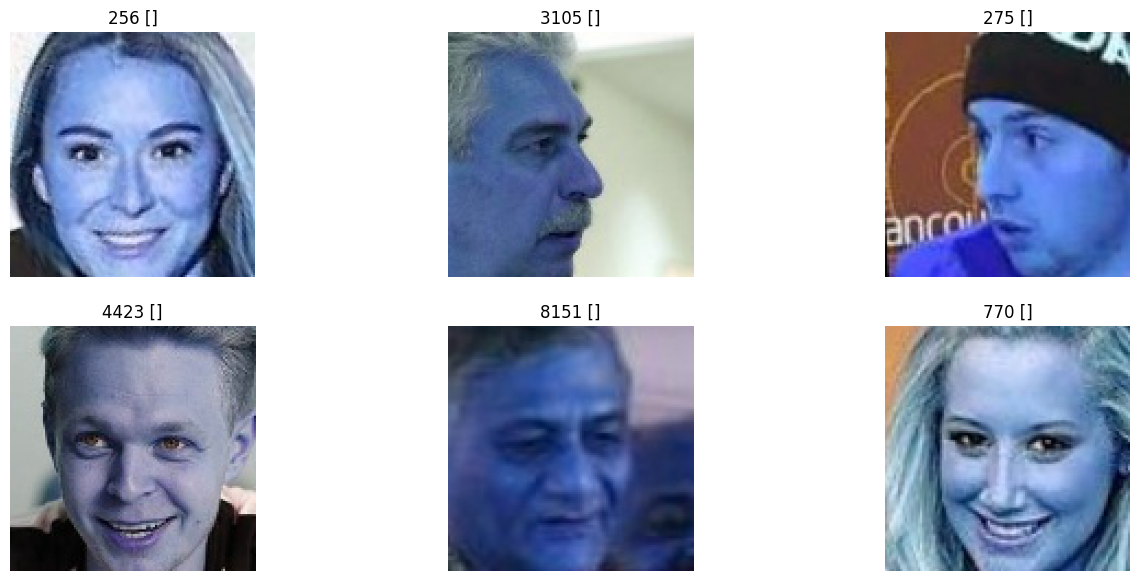

In [38]:
samples = sample_from_derectory(r"C:\Users\asiclab06\Datasets\faces_vgg_112x112\imgs",['unknown','1','2'])

# Conclusion 
* 각 class에 대해서 abnormal한 class를 분류하는 ImageNet을 pre-train한 vgg16,resnet101을 backbone으로 OC-CNN의 간단한 확장(BoN)을 통해 unknown class를 분류 가능한 multi classification 가능
* BoN 으로 inner 클래스인 face verification은 수행 불가
* 다음 BoN_arc_pytorch.ipynb에서 다른 접근 방식 도입

In [83]:
c.eval()
c_cell = torch.jit.trace(c,(inp))
print(c_cell)

BoNet(
  original_name=BoNet
  (backbone): MobileFaceNet(
    original_name=MobileFaceNet
    (conv1): Conv_block(
      original_name=Conv_block
      (conv): Conv2d(original_name=Conv2d)
      (bn): BatchNorm2d(original_name=BatchNorm2d)
      (prelu): PReLU(original_name=PReLU)
    )
    (conv2_dw): Conv_block(
      original_name=Conv_block
      (conv): Conv2d(original_name=Conv2d)
      (bn): BatchNorm2d(original_name=BatchNorm2d)
      (prelu): PReLU(original_name=PReLU)
    )
    (conv_23): Depth_Wise(
      original_name=Depth_Wise
      (conv): Conv_block(
        original_name=Conv_block
        (conv): Conv2d(original_name=Conv2d)
        (bn): BatchNorm2d(original_name=BatchNorm2d)
        (prelu): PReLU(original_name=PReLU)
      )
      (conv_dw): Conv_block(
        original_name=Conv_block
        (conv): Conv2d(original_name=Conv2d)
        (bn): BatchNorm2d(original_name=BatchNorm2d)
        (prelu): PReLU(original_name=PReLU)
      )
      (project): Linear_block(
 

In [85]:
c_cell(inp)

tensor([[  9.8152, -18.9359,   5.6757],
        [  6.1103,  -9.6433,   2.0127],
        [ 22.0794, -50.4987,  18.5653],
        [ 16.7947, -34.0328,  11.0711],
        [ 19.1206, -44.6618,  16.7566],
        [ 25.5666, -64.8891,  26.3287]], device='cuda:0',
       grad_fn=<MmBackward0>)

In [86]:
c_cell.graph

graph(%self.1 : __torch__.___torch_mangle_631.BoNet,
      %x.1 : Float(6, 3, 112, 112, strides=[37632, 1, 336, 3], requires_grad=0, device=cuda:0)):
  %clf : __torch__.torch.nn.modules.container.___torch_mangle_626.Sequential = prim::GetAttr[name="clf"](%self.1)
  %relu : __torch__.torch.nn.modules.activation.___torch_mangle_628.ReLU = prim::GetAttr[name="relu"](%self.1)
  %bn : __torch__.torch.nn.modules.batchnorm.___torch_mangle_629.BatchNorm1d = prim::GetAttr[name="bn"](%self.1)
  %backbone : __torch__.lib.mobilefacenet.___torch_mangle_620.MobileFaceNet = prim::GetAttr[name="backbone"](%self.1)
  %3236 : Tensor = prim::CallMethod[name="forward"](%backbone, %x.1)
  %3237 : Tensor = prim::CallMethod[name="forward"](%bn, %3236)
  %3238 : Tensor = prim::CallMethod[name="forward"](%relu, %3237)
  %3239 : Tensor = prim::CallMethod[name="forward"](%clf, %3238)
  return (%3239)

In [88]:
print(c_cell.code)

def forward(self,
    x: Tensor) -> Tensor:
  clf = self.clf
  relu = self.relu
  bn = self.bn
  backbone = self.backbone
  _0 = (bn).forward((backbone).forward(x, ), )
  return (clf).forward((relu).forward(_0, ), )

